Installing requirements

In [ ]:
!pip install prophet
!pip install -U plotly

Importing Libraries

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from scipy.stats import chi2_contingency

Cleaning dataset

In [ ]:
df = pd.read_csv('../datasets/police_shootings_cleaned.csv')
df['armed'].fillna('unknown', inplace=True)
df['flee'].fillna('unknown', inplace=True)
df['gender'].fillna('unknown', inplace=True)
df['race'].fillna('unknown', inplace=True)
df['signs_of_mental_illness'].fillna('unknown', inplace=True)

Workflow 1

Generating treemap

In [8]:
armed_counts = df['armed'].value_counts(normalize=True) * 100
armed_counts = armed_counts.reset_index()
armed_counts.columns = ['Armed', 'Percentage']

armed_counts = armed_counts[armed_counts['Percentage'] >= 0.35]

fig = px.treemap(
    armed_counts,
    path=['Armed'],
    values='Percentage',
    title='Percentages of Armed Status in Police Shootings'
)

fig.update_traces(
    textinfo='label+percent parent',
    hovertemplate='<b>%{label}</b><br>Percentage: %{value:.2f}%<extra></extra>'
)
fig.show()

# shows on google colab, but for some reason not on vscode, however, plot image and plot html are saved in outputs folder

Creating output directory

In [9]:
# prompt: if directory ./outputs doesn't exist, create it

import os

if not os.path.exists('./outputs'):
    os.makedirs('./outputs')

Saving first treemap html file

In [10]:
# prompt: use plotly to save the html only as 1.html

pio.write_html(fig, file='./outputs/Owais_1.html', auto_open=False)


Generating initial line plot

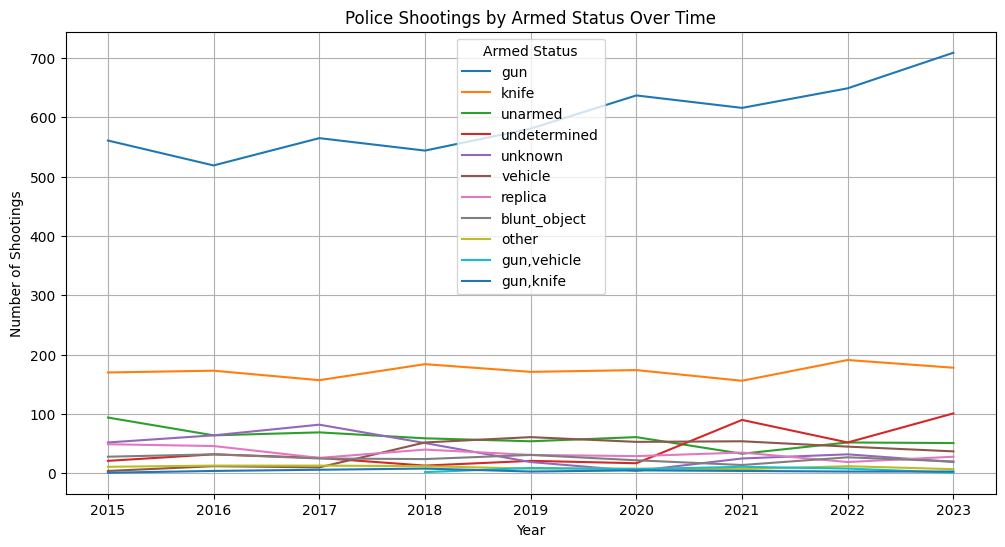

In [11]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# year 2024 removed
df = df[df['year'] != 2024]

# Group by year and armed status, and count occurrences
armed_by_year = df.groupby(['year', 'armed']).size().reset_index(name='counts')

# Filter for armed statuses with percentages >= 0.35 (same as treemap)
armed_counts = df['armed'].value_counts(normalize=True) * 100
armed_counts = armed_counts.reset_index()
armed_counts.columns = ['Armed', 'Percentage']
armed_counts = armed_counts[armed_counts['Percentage'] >= 0.35]
relevant_armed_statuses = armed_counts['Armed'].tolist()
armed_by_year = armed_by_year[armed_by_year['armed'].isin(relevant_armed_statuses)]

# Create the line plot
plt.figure(figsize=(12, 6))
for armed_status in relevant_armed_statuses:
    subset = armed_by_year[armed_by_year['armed'] == armed_status]
    plt.plot(subset['year'], subset['counts'], label=armed_status)

plt.xlabel('Year')
plt.ylabel('Number of Shootings')
plt.title('Police Shootings by Armed Status Over Time')
plt.legend(title='Armed Status')
plt.grid(True)
plt.savefig('./outputs/Owais_2.png', dpi=300, bbox_inches='tight')
plt.show()


Generating monthly yearly timeplot

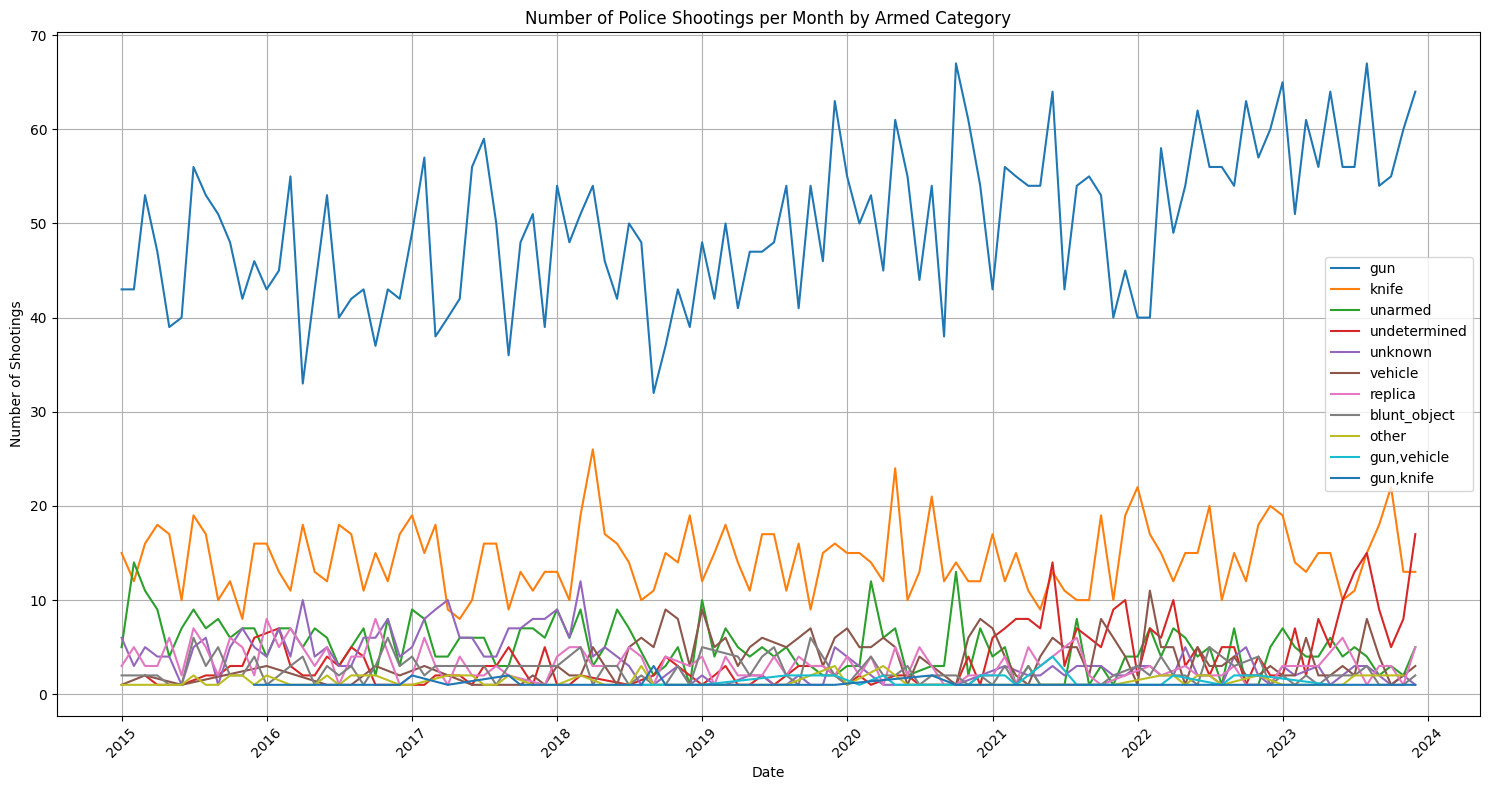

In [12]:
# Convert the date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filter for armed categories with at least 0.35% representation
armed_counts = df['armed'].value_counts(normalize=True) * 100
armed_counts = armed_counts.reset_index()
armed_counts.columns = ['Armed', 'Percentage']
armed_categories = armed_counts[armed_counts['Percentage'] >= 0.35]['Armed'].tolist()
df_filtered = df[df['armed'].isin(armed_categories)]

# Group by year, month, and armed category
monthly_counts = df_filtered.groupby(['year', 'month', 'armed']).size().reset_index()

# Create the line plot
plt.figure(figsize=(15, 8))
for armed_category in armed_categories:
    category_data = monthly_counts[monthly_counts['armed'] == armed_category]
    # plt.plot(pd.to_datetime(category_data['year'].astype(str) + '-' + category_data['month'].astype(str), format='%Y-%m'), category_data['id'], label=armed_category)
    plt.plot(pd.to_datetime(category_data['year'].astype(str) + '-' + category_data['month'].astype(str), format='%Y-%m'), category_data[0], label=armed_category)

plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.title('Number of Police Shootings per Month by Armed Category')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./outputs/Owais_3.png', dpi=300, bbox_inches='tight')
plt.show()

generating only monthly timeplot

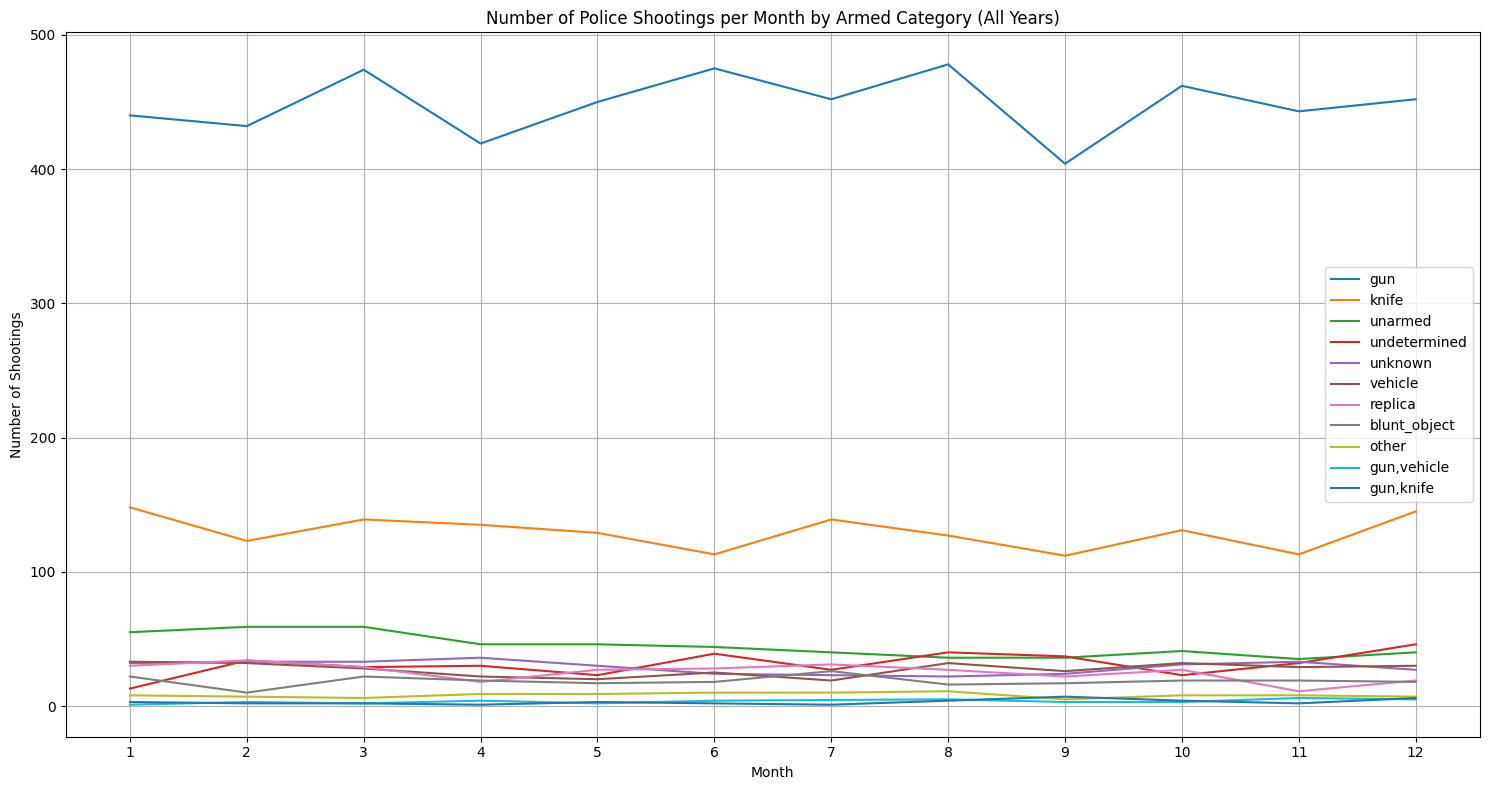

In [13]:
# prompt: generate aggreagate stats per month # id does not exist (like jan(all years), feb(all years) ) do line graph

# Group data by month and count occurrences for each armed category
monthly_counts = df_filtered.groupby(['month', 'armed']).size().reset_index(name='counts')

# Create the line plot
plt.figure(figsize=(15, 8))
for armed_category in armed_categories:
    category_data = monthly_counts[monthly_counts['armed'] == armed_category]
    plt.plot(category_data['month'], category_data['counts'], label=armed_category)

plt.xlabel('Month')
plt.ylabel('Number of Shootings')
plt.title('Number of Police Shootings per Month by Armed Category (All Years)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))  # Ensure all months are displayed on x-axis
plt.tight_layout()
plt.savefig('./outputs/Owais_4.png', dpi=300, bbox_inches='tight')
plt.show()

generating composite visualization with average and actual values

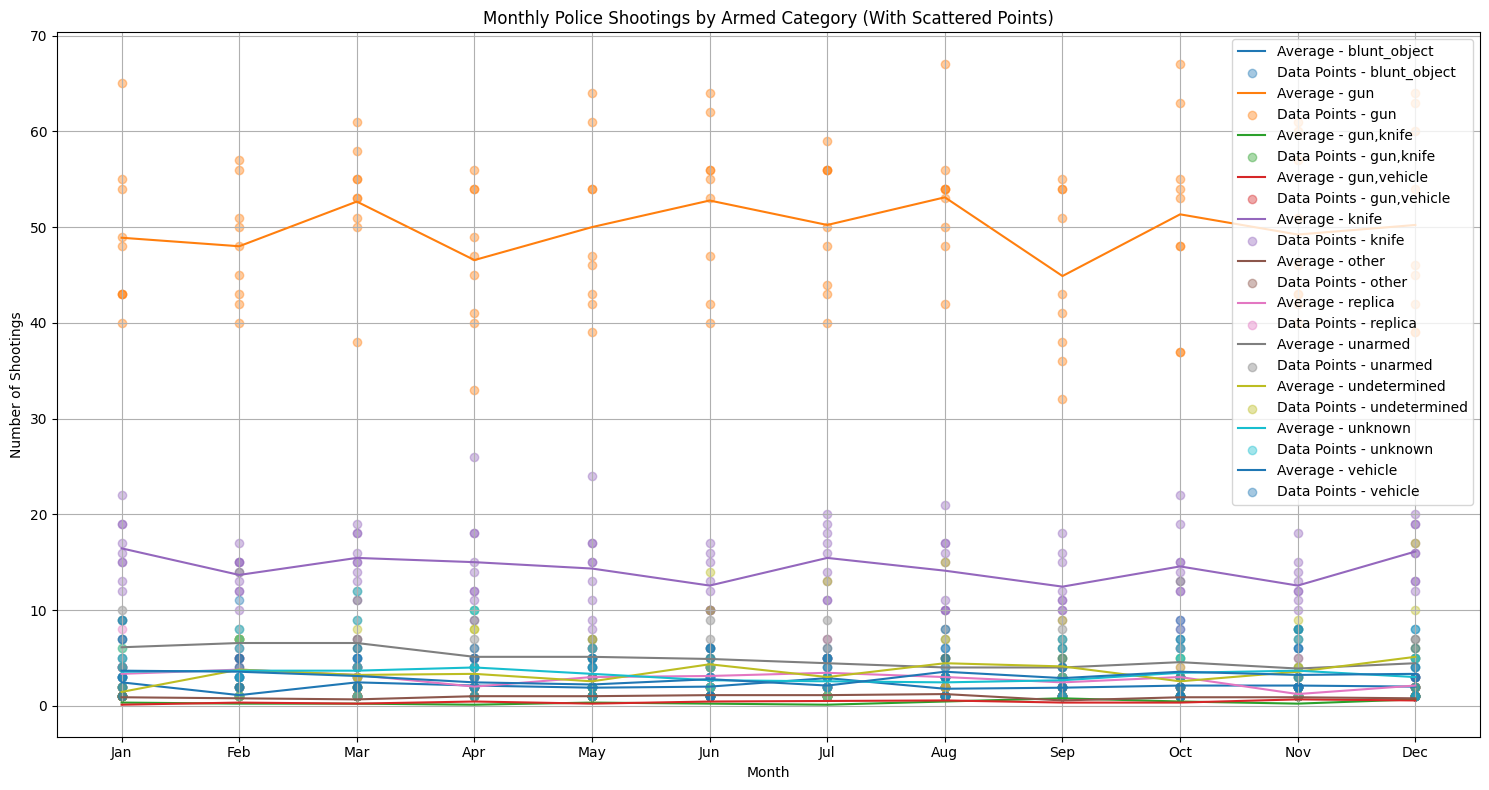

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of unique years in the dataset
num_years = df_filtered['year'].nunique()

# Group by month and armed status to calculate the average statistics
monthly_avg = (
    df_filtered.groupby(['month', 'armed'])
    .size()
    .reset_index(name='counts')  # Add a 'counts' column
)
monthly_avg['average'] = monthly_avg['counts'] / num_years  # Calculate the average per year

# Group by year, month, and armed status for the actual data points
actual_data = (
    df_filtered.groupby(['year', 'month', 'armed'])
    .size()
    .reset_index(name='counts')  # Add a 'counts' column
)

# Plot the line graph with scattered points
plt.figure(figsize=(15, 8))

# Iterate over each armed category
for armed_category in monthly_avg['armed'].unique():
    # Plot the average line for the category
    category_avg = monthly_avg[monthly_avg['armed'] == armed_category]
    plt.plot(
        category_avg['month'],
        category_avg['average'],  # Use the average instead of raw counts
        label=f'Average - {armed_category}'
    )

    # Scatter the actual data points for the category
    category_actual = actual_data[actual_data['armed'] == armed_category]
    plt.scatter(
        category_actual['month'],
        category_actual['counts'],
        alpha=0.4,
        label=f'Data Points - {armed_category}'
    )

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Number of Shootings')
plt.title('Monthly Police Shootings by Armed Category (With Scattered Points)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./outputs/Owais_5.png', dpi=300, bbox_inches='tight')
plt.show()

running a forecasting model

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (adjust df as per your dataset structure)
df['date'] = pd.to_datetime(df['date'])

# Step 1: Filter data for armed categories with >= 0.35% representation
armed_counts = df['armed'].value_counts(normalize=True) * 100
armed_categories = armed_counts[armed_counts >= 0.35].index.tolist()
df_filtered = df[df['armed'].isin(armed_categories)]

# Step 2: Train-Test Split
train_start = '2015-01-01'
train_end = '2019-12-31'
forecast_start = '2020-01-01'
forecast_end = '2023-12-31'

# Step 3: Forecast for each armed category
forecast_results = {}
actual_results = {}
for armed_category in armed_categories:
    category_data = df_filtered[df_filtered['armed'] == armed_category]
    category_data['count'] = 1

    # Aggregate monthly data for training
    monthly_data = category_data.resample('M', on='date').sum().reset_index()
    train_data = monthly_data[
        (monthly_data['date'] >= train_start) & (monthly_data['date'] <= train_end)
    ][['date', 'count']].rename(columns={'date': 'ds', 'count': 'y'})

    # Fit Prophet model
    model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    model.fit(train_data)

    # Create future dataframe for forecasting
    future = model.make_future_dataframe(
        periods=(pd.to_datetime(forecast_end) - pd.to_datetime(forecast_start)).days // 30 + 1,
        freq='M'
    )
    forecast = model.predict(future)
    forecast = forecast[
        (forecast['ds'] >= forecast_start) & (forecast['ds'] <= forecast_end)
    ]

    # Store forecasted results
    forecast_results[armed_category] = forecast

    # Step 4: Get actual data for comparison (from original dataset)
    actual_data = category_data[
        (category_data['date'] >= forecast_start) & (category_data['date'] <= forecast_end)
    ].resample('M', on='date').sum().reset_index()

    actual_data['month'] = actual_data['date'].dt.to_period('M')
    actual_results[armed_category] = actual_data


plotting forecasted vs actual data

<ipython-input-16-d8ef29883415>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



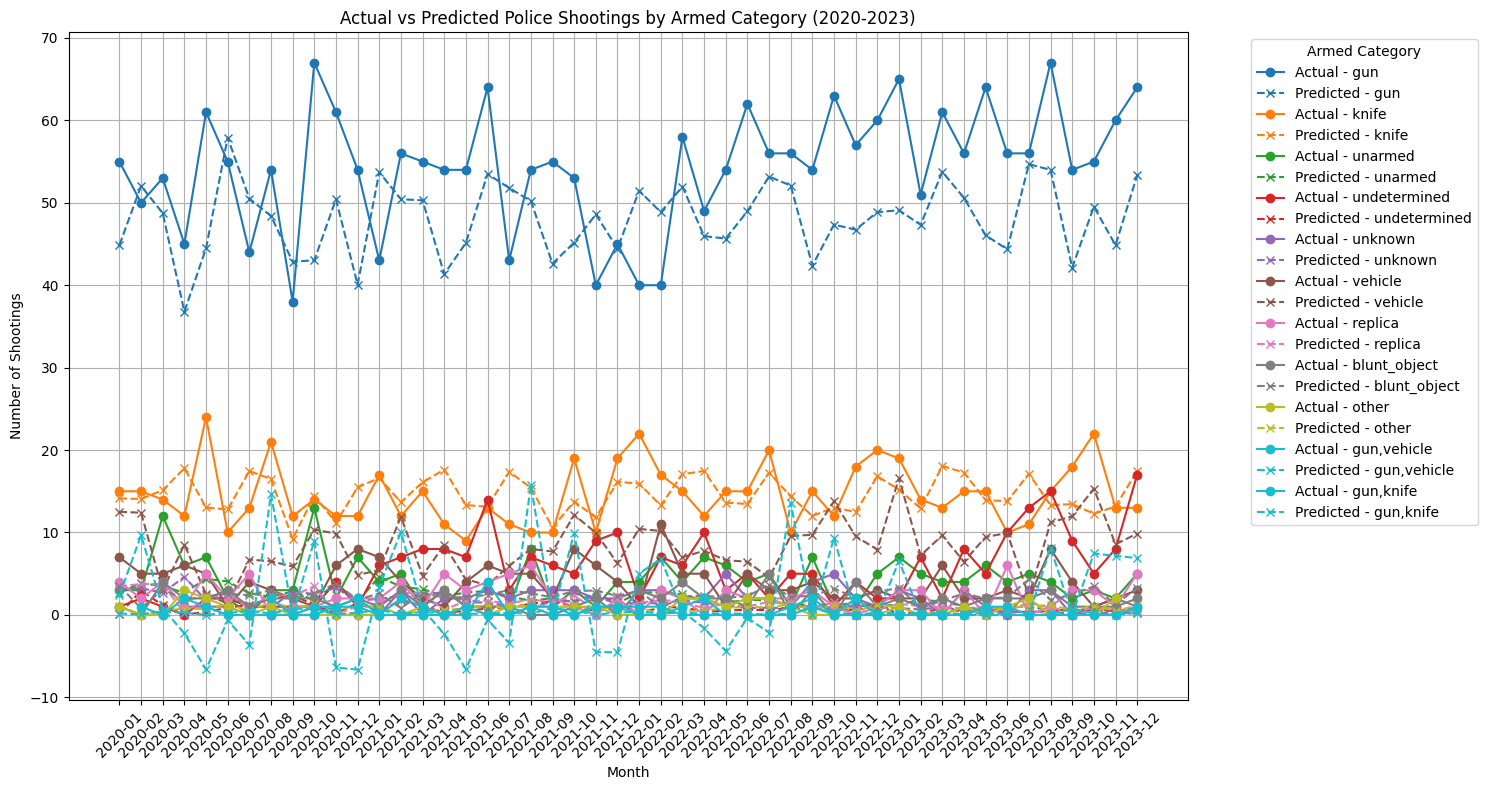

In [16]:

plt.figure(figsize=(15, 8))

# Create a color map for different armed categories
colors = plt.cm.get_cmap('tab10', len(armed_categories))  # Use a qualitative colormap

for i, armed_category in enumerate(armed_categories):
    forecast = forecast_results[armed_category]
    actual_data = actual_results[armed_category]

    # Plot actual data
    plt.plot(
        actual_data['month'].dt.strftime('%Y-%m'),
        actual_data['count'],
        label=f'Actual - {armed_category}',
        linestyle='-',
        marker='o',
        color=colors(i)  # Assign color from the colormap
    )

    # Plot predicted data
    forecast['month'] = pd.to_datetime(forecast['ds']).dt.to_period('M')
    monthly_forecast = forecast.groupby('month')['yhat'].mean().reset_index()

    plt.plot(
        monthly_forecast['month'].dt.strftime('%Y-%m'),
        monthly_forecast['yhat'],
        label=f'Predicted - {armed_category}',
        linestyle='--',
        marker='x',
        color=colors(i)  # Use the same color as the actual data
    )

# Customize the plot (your existing code)
plt.xlabel('Month')
plt.ylabel('Number of Shootings')
plt.title('Actual vs Predicted Police Shootings by Armed Category (2020-2023)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Armed Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/Owais_6.png', dpi=300, bbox_inches='tight')
plt.show()

plotting subset of data from forecast and actual

<ipython-input-17-8afa3b727b8b>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



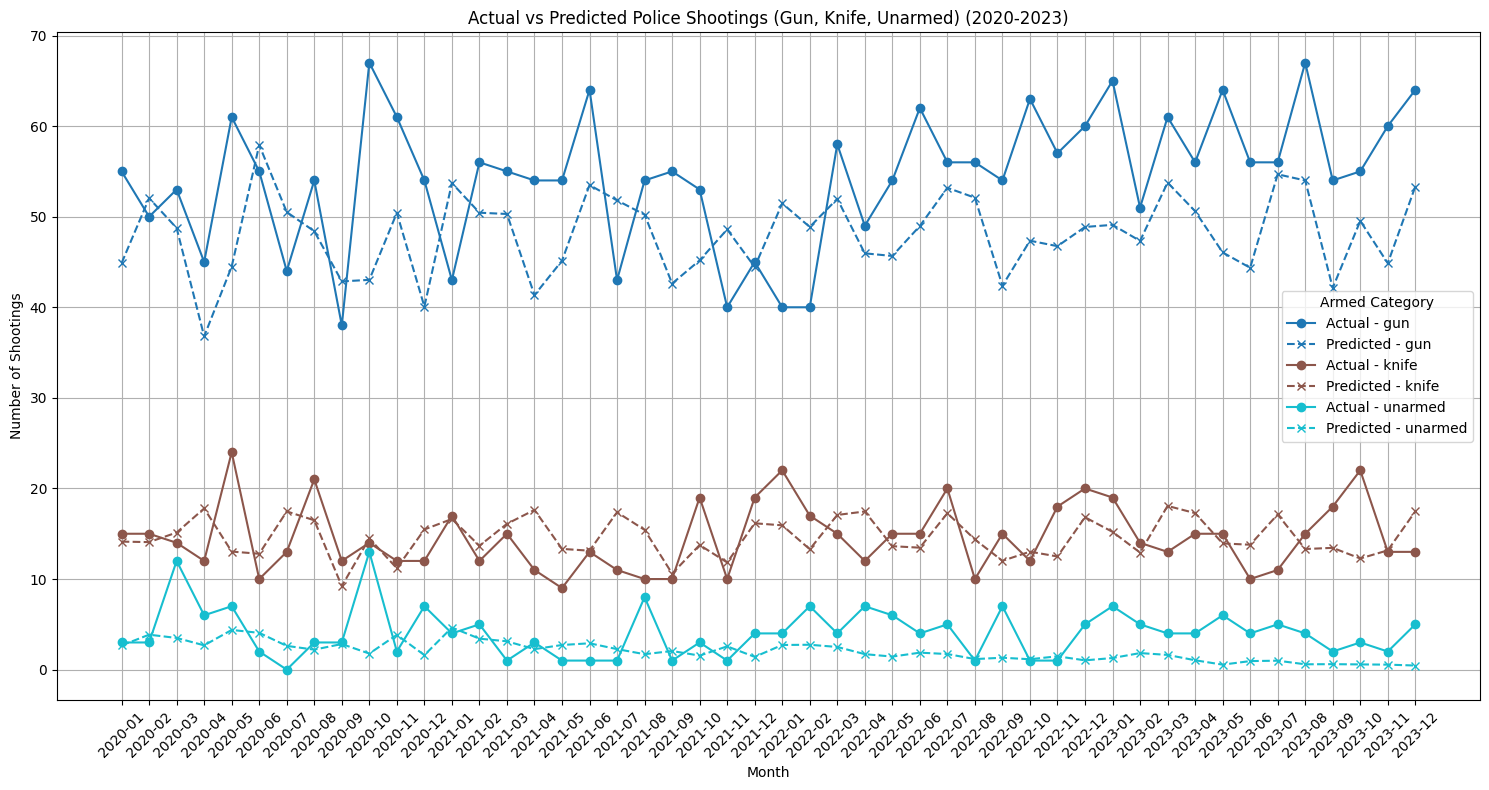

In [17]:
plt.figure(figsize=(15, 8))
selected_categories = ['gun', 'knife', 'unarmed']
colors = plt.cm.get_cmap('tab10', len(selected_categories))

for i, armed_category in enumerate(selected_categories):
    if armed_category in armed_categories:
        forecast = forecast_results[armed_category]
        actual_data = actual_results[armed_category]

        # Plot actual data
        plt.plot(
            actual_data['month'].dt.strftime('%Y-%m'),
            actual_data['count'],
            label=f'Actual - {armed_category}',
            linestyle='-',
            marker='o',
            color=colors(i)
        )

        # Plot predicted data
        forecast['month'] = pd.to_datetime(forecast['ds']).dt.to_period('M')
        monthly_forecast = forecast.groupby('month')['yhat'].mean().reset_index()

        plt.plot(
            monthly_forecast['month'].dt.strftime('%Y-%m'),
            monthly_forecast['yhat'],
            label=f'Predicted - {armed_category}',
            linestyle='--',
            marker='x',
            color=colors(i)
        )

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Number of Shootings')
plt.title('Actual vs Predicted Police Shootings (Gun, Knife, Unarmed) (2020-2023)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Armed Category')  # Removed bbox_to_anchor for better legend placement
plt.tight_layout()
plt.savefig('./outputs/Owais_7.png', dpi=300, bbox_inches='tight')
plt.show()

Workflow 2

generating contingency tables, and running chi-squared model over pairwise categories

Chi-squared test for independence between 'armed' and 'flee':
Chi2 statistic: 1935.9826383009902
P-value: 0.0
Degrees of freedom: 88
--------------------------------------------------


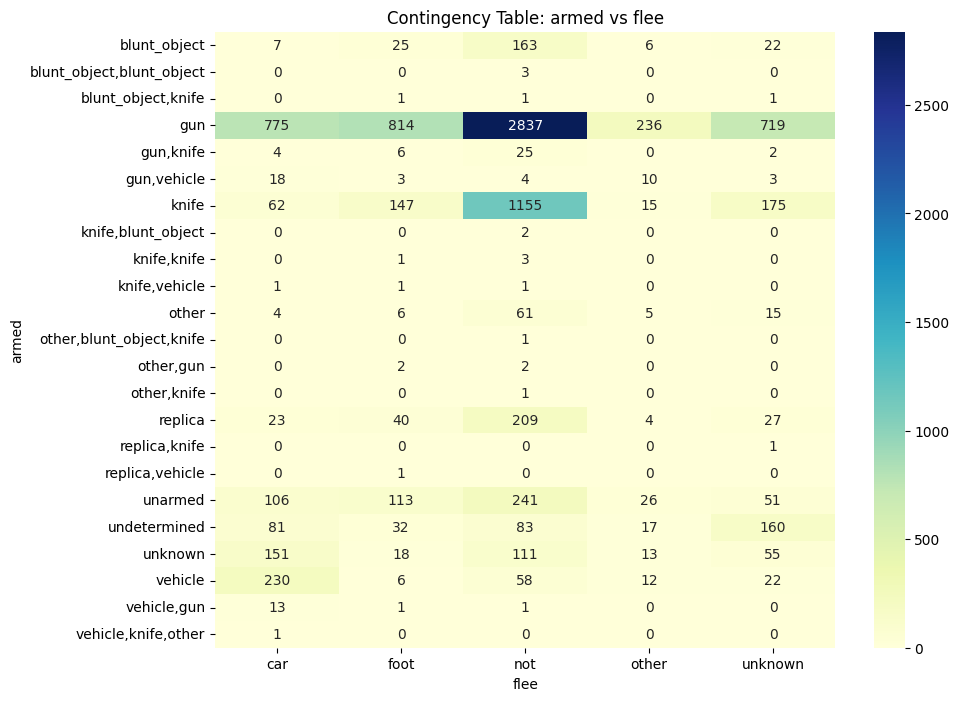

Chi-squared test for independence between 'signs_of_mental_illness' and 'flee':
Chi2 statistic: 452.9493330732694
P-value: 1.0005414136127088e-96
Degrees of freedom: 4
--------------------------------------------------


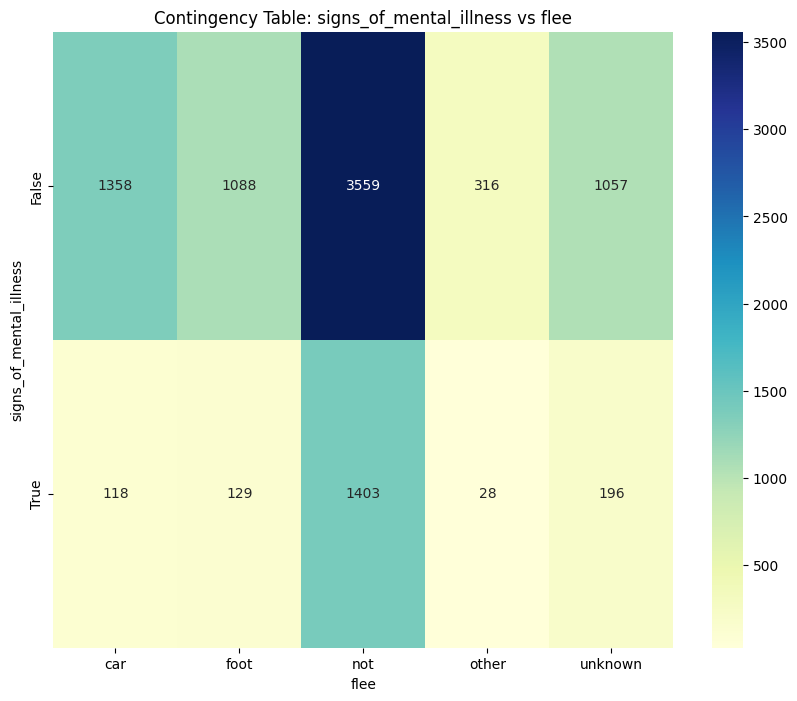

Chi-squared test for independence between 'armed' and 'signs_of_mental_illness':
Chi2 statistic: 388.89155653241534
P-value: 8.022268880024748e-69
Degrees of freedom: 22
--------------------------------------------------


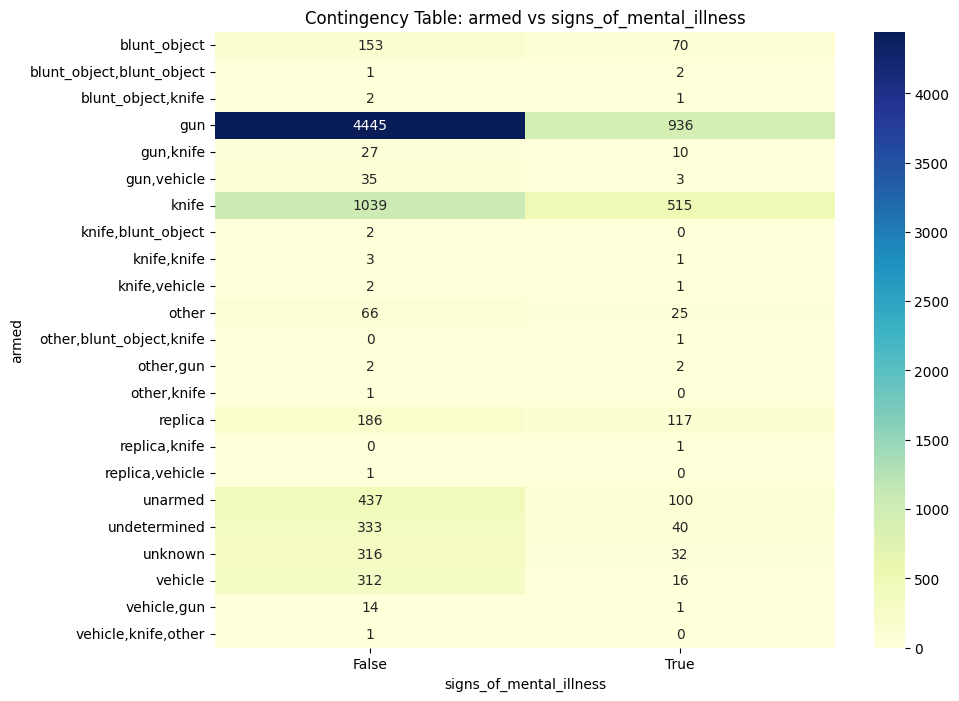

Chi-squared test for independence between 'body_camera' and 'flee':
Chi2 statistic: 34.10002099346726
P-value: 7.108074707231791e-07
Degrees of freedom: 4
--------------------------------------------------


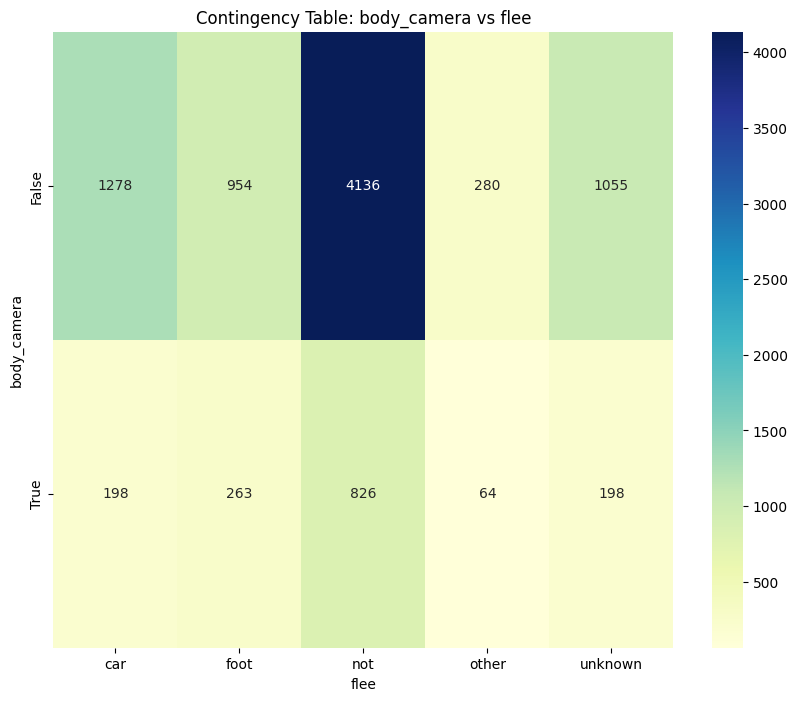

In [18]:
def run_chi2_test(df, col1, col2, i):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test for independence between '{col1}' and '{col2}':")
    print(f"Chi2 statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("-" * 50)

    # Visualization using heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Contingency Table: {col1} vs {col2}")
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.savefig(f'./outputs/Owais_8_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

attributes_list = [ ['armed', 'flee'], ['signs_of_mental_illness', 'flee'], ['armed', 'signs_of_mental_illness'] , ['body_camera', 'flee']]
# for attributes in attributes_list:
for i in range(len(attributes_list)):
      run_chi2_test(df, attributes_list[i][0], attributes_list[i][1], i+1)